In [1]:
1+1

2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/original" -d "/content/original"

In [6]:
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ───────────────────────────────────────────────────────────────
# 1. 기본 경로 설정
# Colab 기준: '/content/' 폴더 아래에 original/ 폴더가 있다고 가정
base_dir       = '/content'
original_dir   = "/content/original/original"        # 원본 이미지가 클래스별로 들어있는 폴더
split_dir      = os.path.join(base_dir, 'split_data')        # train/val 폴더를 생성할 최상위 디렉토리
train_orig_dir = os.path.join(split_dir, 'train')            # split된 train 원본(70%) 디렉토리
val_orig_dir   = os.path.join(split_dir, 'val')              # split된 val 원본(30%) 디렉토리

aug_local_root = os.path.join(base_dir, 'augmentation3_local')
# → 최종 “원본 train(70%) + 오프라인 증강본(70% × 3)”을 저장할 폴더

# 증강 비율: 원본 1장당 k_per_image개 생성
k_per_image = 3

# ───────────────────────────────────────────────────────────────
# 2. split_data/train, split_data/val 폴더 생성하기 (원본을 70:30으로 나누기)
classes = sorted(os.listdir(original_dir))
# 참고: original/ 하위에 반드시 클래스별 폴더만 있고, 불필요한 파일이 없어야 합니다.

# (1) split_data, train, val 기본 디렉토리 생성
os.makedirs(train_orig_dir, exist_ok=True)
os.makedirs(val_orig_dir, exist_ok=True)

for cls in classes:
    src_cls_folder = os.path.join(original_dir, cls)
    if not os.path.isdir(src_cls_folder):
        continue  # 만약 이미지 파일이 아니라 딴 파일이 섞여 있으면 건너뛰기

    # 클래스별 train/val 디렉토리 경로
    train_cls_folder = os.path.join(train_orig_dir, cls)
    val_cls_folder   = os.path.join(val_orig_dir, cls)
    os.makedirs(train_cls_folder, exist_ok=True)
    os.makedirs(val_cls_folder, exist_ok=True)

    # (2) 클래스별로 파일 목록을 불러와서 shuffle 후 70:30 비율로 나누기
    all_files = [fname for fname in os.listdir(src_cls_folder)
                 if os.path.isfile(os.path.join(src_cls_folder, fname))]
    random.shuffle(all_files)

    n_total = len(all_files)
    n_train = int(n_total * 0.7)   # 70% → train
    # 나머지 30% → val
    train_files = all_files[:n_train]
    val_files   = all_files[n_train:]

    # (3) train_files를 split_data/train/[cls]/ 로 복사
    for fname in train_files:
        src_path = os.path.join(src_cls_folder, fname)
        dst_path = os.path.join(train_cls_folder, fname)
        shutil.copy(src_path, dst_path)

    # (4) val_files를 split_data/val/[cls]/ 로 복사
    for fname in val_files:
        src_path = os.path.join(src_cls_folder, fname)
        dst_path = os.path.join(val_cls_folder, fname)
        shutil.copy(src_path, dst_path)

# ───────────────────────────────────────────────────────────────
# 3. 오프라인 증강을 위해 augmentation3_local 폴더 구조 만들기
#    그리고 train_orig_dir(70% 원본)을 여기에 복사(원본 train 70% 포함),
#    이후 ImageDataGenerator를 통해 증강본을 동일 폴더에 저장

# (1) augmentation3_local 및 클래스별 서브폴더 생성
os.makedirs(aug_local_root, exist_ok=True)
for cls in classes:
    cls_folder = os.path.join(aug_local_root, cls)
    os.makedirs(cls_folder, exist_ok=True)

# (2) 먼저 “원본 train(70%)”을 augmentation3_local/[cls]로 복사
for cls in classes:
    src_train_cls = os.path.join(train_orig_dir, cls)   # split_data/train/[cls]
    dst_aug_cls   = os.path.join(aug_local_root, cls)   # augmentation3_local/[cls]
    if not os.path.isdir(src_train_cls):
        continue
    for fname in os.listdir(src_train_cls):
        src_path = os.path.join(src_train_cls, fname)
        dst_path = os.path.join(dst_aug_cls, fname)
        shutil.copy(src_path, dst_path)

# ───────────────────────────────────────────────────────────────
# 4. ImageDataGenerator 객체 정의 (오프라인 증강용)
datagen = ImageDataGenerator(
    rescale=1./255,        # 필요에 따라 스케일만 해 주거나(단 rescale은 옵션)
    rotation_range=20,     # 회전 범위
    width_shift_range=0.1, # 좌우 이동
    height_shift_range=0.1,# 상하 이동
    shear_range=0.1,       # 전단 변환
    zoom_range=0.1,        # 확대/축소
    horizontal_flip=True,  # 좌우 뒤집기
    fill_mode='nearest'    # 빈 공간을 가장 가까운 픽셀로 채우기
)

# ───────────────────────────────────────────────────────────────
# 5. 오프라인 증강 수행: train_orig_dir → augmentation3_local 에 k_per_image개씩 추가 생성

for cls in classes:
    # (1) flow_from_directory를 위해 ‘클래스 폴더만 읽어오는’ 폴더 설정
    #     ImageDataGenerator.flow_from_directory는 상위 폴더를 지정하고 classes 를 통해 특정 클래스만 읽을 수도 있지만,
    #     여기서는 train_orig_dir 아래에 이미 클래스별 폴더가 있으므로,
    #     gen = datagen.flow_from_directory(directory=train_orig_dir, classes=[cls], ...) 처럼 사용할 수 있습니다.

    src_for_aug = train_orig_dir        # split_data/train (클래스별 서브폴더 있음)
    dst_for_aug = os.path.join(aug_local_root, cls)

    # flow_from_directory로 해당 클래스를 하나씩 읽어들임
    gen = datagen.flow_from_directory(
        directory=src_for_aug,
        classes=[cls],
        target_size=(224, 224),  # 필요에 따라 원본 크기와 맞추거나 원하는 크기 지정
        batch_size=1,            # 1장씩 증강
        class_mode=None,         # 라벨을 따로 만들 필요 없음
        save_to_dir=dst_for_aug, # augmentation3_local/[cls]에 저장
        save_prefix=f'aug_{cls}',# 저장파일 접두사
        save_format='jpeg',      # 저장 포맷 (jpeg 혹은 png 등)
        shuffle=False            # 파일 순서대로 읽어가므로 shuffle=False
    )

    # (2) 총 원본 train 이미지 개수 * k_per_image만큼 증강본 생성
    #     gen.samples는 해당 클래스 train 이미지 개수(70% 원본)
    n_train_samples = gen.samples
    n_to_generate   = n_train_samples * k_per_image

    print(f'>>> 클래스 [{cls}]에 대해 원본 {n_train_samples}장 × {k_per_image} = {n_to_generate}장 증강을 생성합니다.')
    for i in range(n_to_generate):
        batch = next(gen)  # 내부적으로 이미지를 불러와서 증강하고, 지정된 폴더에 저장해 줌

print('>>> 오프라인 증강이 모두 완료되었습니다!')


Found 2327 images belonging to 1 classes.
>>> 클래스 [glioma]에 대해 원본 2327장 × 3 = 6981장 증강을 생성합니다.
Found 4692 images belonging to 1 classes.
>>> 클래스 [healthy]에 대해 원본 4692장 × 3 = 14076장 증강을 생성합니다.
Found 2286 images belonging to 1 classes.
>>> 클래스 [meningioma]에 대해 원본 2286장 × 3 = 6858장 증강을 생성합니다.
Found 2081 images belonging to 1 classes.
>>> 클래스 [pituitary]에 대해 원본 2081장 × 3 = 6243장 증강을 생성합니다.
>>> 오프라인 증강이 모두 완료되었습니다!


In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --------------------------------------------------------
# 1) 데이터 제너레이터(실시간 증강 + split)
# --------------------------------------------------------

data_gen1 = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,   # 30%를 검증으로 떼어냄
    rotation_range=15,      # 증강 강도 ↑
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
data_gen2 = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

# 3) train / validation 제너레이터 생성
# Assuming 'classes' variable contains the list of 4 class names
train_gen = data_gen1.flow_from_directory(
    aug_local_root,
    target_size=(128, 128),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    classes=classes # Specify the expected classes
)

val_gen = data_gen2.flow_from_directory(
    val_orig_dir, # Note: val_gen uses train_orig_dir for splitting the original 70% train data into 30% validation
    target_size=(128, 128),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',  # 30% 검증용
    shuffle=False,
    classes=classes # Specify the expected classes
)

# The rest of the code for model definition and training remains the same.
# Ensure the model's final Dense layer has the correct number of units,
# which is 4 in this case, matching the number of classes.

Found 45544 images belonging to 4 classes.
Found 1463 images belonging to 4 classes.


In [30]:
# 4) 콜백 설정 (Optional)
from tensorflow.keras import callbacks

earlystop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,          # ← 조금 더 넉넉히
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,       # ← 2 → 4로 늘려서 “4번 epoch 연속 개선 없을 때만” lr 줄이기
    min_lr=1e-7,      # ← 학습률이 너무 작아져서 학습이 멈추는 것을 방지하기 위해 최저 lr 설정
    verbose=1
)

In [9]:
# --------------------------------------------------------
# 2) 모델 정의: L2 Regularizer 적용 + Dropout 비율 상향
# --------------------------------------------------------
model_v6_1_reg = models.Sequential([
    layers.Input(shape=(128, 128, 1)),        # 1채널 입력
    layers.GaussianNoise(0.05),               # Gaussian noise 추가 (기존과 동일)

    # --- Block 1 ---
    layers.Conv2D(32, (3,3), padding='same',
                  activation='relu',
                  kernel_regularizer=regularizers.l2(1e-3)),  # λ=1e-3
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), padding='same',
                  activation='relu',
                  kernel_regularizer=regularizers.l2(1e-3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),  # 기존 0.2 → 0.3

    # --- Block 2 ---
    layers.Conv2D(64, (3,3), padding='same',
                  activation='relu',
                  kernel_regularizer=regularizers.l2(1e-3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), padding='same',
                  activation='relu',
                  kernel_regularizer=regularizers.l2(1e-3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),  # 기존 0.2 → 0.3

    # --- Block 3 ---
    layers.Conv2D(128, (3,3), padding='same',
                  activation='relu',
                  kernel_regularizer=regularizers.l2(1e-3)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), padding='same',
                  activation='relu',
                  kernel_regularizer=regularizers.l2(1e-3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.4),  # 기존 0.2 → 0.4

    # --- Classification Head ---
    layers.GlobalAveragePooling2D(),
    layers.Dense(128,
                 activation='relu',
                 kernel_regularizer=regularizers.l2(1e-3)),
    layers.Dropout(0.5),  # 기존 0.3 → 0.5
    layers.Dense(4, activation='softmax')
])

# --------------------------------------------------------
# 3) 컴파일: 학습률을 다소 낮춘 상태에서 시작
# --------------------------------------------------------
model_v6_1_reg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # 기존 1e-3 → 1e-4
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_v6_1_reg.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 305,252 (1.16 MB)

 Trainable params: 304,356 (1.16 MB)

 Non-trainable params: 896 (3.50 KB)

In [10]:
# --------------------------------------------------------
# 4) 학습 호출: callbacks는 기존과 동일하게 사용
# --------------------------------------------------------
history6_1_reg = model_v6_1_reg.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    epochs=50,
    validation_data=val_gen,
    validation_steps=val_gen.samples // val_gen.batch_size,
    callbacks=[earlystop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 156s 192ms/step - accuracy: 0.5197 - loss: 1.6079 - val_accuracy: 0.3409 - val_loss: 2.5559 - learning_rate: 1.0000e-04
Epoch 2/50
  1/711 ━━━━━━━━━━━━━━━━━━━━ 1:11 101ms/step - accuracy: 0.6719 - loss: 1.2561

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6719 - loss: 1.2561 - val_accuracy: 0.3423 - val_loss: 2.5479 - learning_rate: 1.0000e-04
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 124s 174ms/step - accuracy: 0.6834 - loss: 1.2210 - val_accuracy: 0.4787 - val_loss: 2.1552 - learning_rate: 1.0000e-04
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7188 - loss: 1.0892 - val_accuracy: 0.4808 - val_loss: 2.1278 - learning_rate: 1.0000e-04
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 142s 200ms/step - accuracy: 0.7436 - loss: 1.0461 - val_accuracy: 0.4474 - val_loss: 2.3363 - learning_rate: 1.0000e-04
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7500 - loss: 1.0101 - val_accuracy: 0.4517 - val_loss: 2.2864 - learning_rate: 1.0000e-04
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 177s 171ms/step - accuracy: 0.7740 - loss: 0.9453 - val_accuracy: 0.4844 - val_loss: 2.5054 - learning_rate: 1.0000e-04
Epoch 8/50
  1/711 ━━━━━━━━━━━━━━━━━━━━ 1:23 118ms/step - accur

In [11]:
import numpy as np

# 1) 최고 Validation Accuracy 구하기
best_val_acc = max(history6_1_reg.history['val_accuracy'])
# 2) 최고 성능일 때의 에폭(1-indexed)
best_epoch = history6_1_reg.history['val_accuracy'].index(best_val_acc) + 1

# 3) 최종 Train Accuracy
final_train_acc = history6_1_reg.history['accuracy'][-1]
# 4) 최종 Validation Accuracy
final_val_acc = history6_1_reg.history['val_accuracy'][-1]

print(f"최고 Validation Accuracy: {best_val_acc:.4f}")
print(f"Epoch (최고 성능 시점): {best_epoch}")
print(f"최종 Train Accuracy: {final_train_acc:.4f}")
print(f"최종 Validation Accuracy: {final_val_acc:.4f}")


최고 Validation Accuracy: 0.7209
Epoch (최고 성능 시점): 30
최종 Train Accuracy: 0.9531
최종 Validation Accuracy: 0.7209


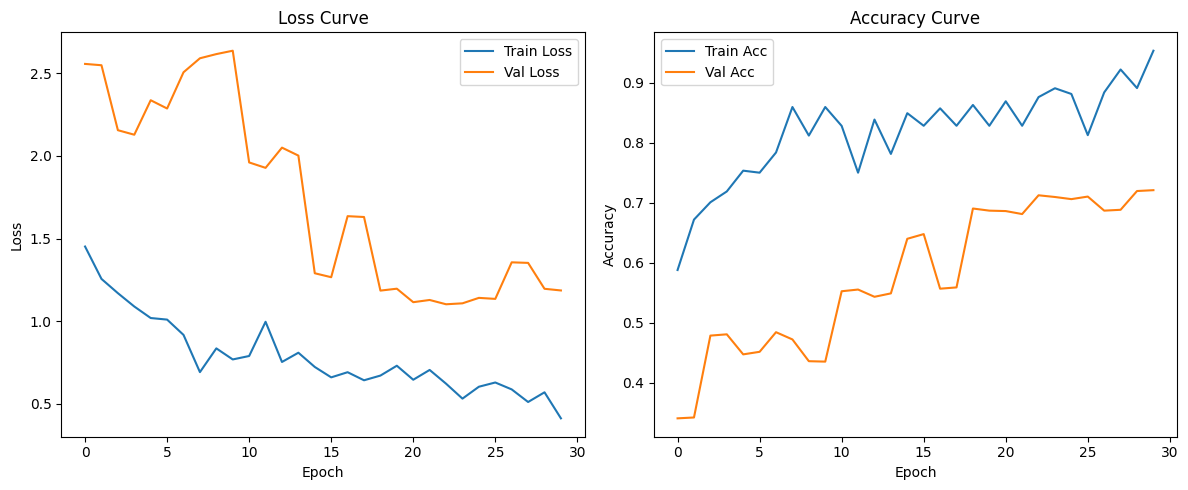

In [12]:
### 시각화 ###
import matplotlib.pyplot as plt

# 1) Figure 크기 설정
plt.figure(figsize=(12, 5))

# 2) Loss 곡선
plt.subplot(1, 2, 1)
plt.plot(history6_1_reg.history['loss'],     label='Train Loss')
plt.plot(history6_1_reg.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 3) Accuracy 곡선
plt.subplot(1, 2, 2)
plt.plot(history6_1_reg.history['accuracy'],     label='Train Acc')
plt.plot(history6_1_reg.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## ResNet(train 학습이 너무 요동치므로 다시)

In [24]:
import os, zipfile, shutil
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

num_classes = len(train_gen_col.class_indices)

# ResNet50 전이학습 모델 구성
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable = False  # 특징 추출기로만 사용

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

resnet_model = Model(inputs=base_model.input, outputs=output)

resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

resnet_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [25]:
# 3) train / validation 제너레이터 생성
# Assuming 'classes' variable contains the list of 4 class names
train_gen_col = data_gen1.flow_from_directory(
    aug_local_root,
    target_size=(128, 128),
    batch_size=64,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    classes=classes # Specify the expected classes
)

val_gen_col = data_gen2.flow_from_directory(
    val_orig_dir, # Note: val_gen_col uses train_orig_dir for splitting the original 70% train data into 30% validation
    target_size=(128, 128),
    batch_size=64,
    color_mode = 'rgb',
    class_mode='categorical',
    subset='validation',  # 30% 검증용
    shuffle=False,
    classes=classes # Specify the expected classes
)

# The rest of the code for model definition and training remains the same.
# Ensure the model's final Dense layer has the correct number of units,
# which is 4 in this case, matching the number of classes.
# --------------------------------------------------------
# 4) 학습 호출: callbacks는 기존과 동일하게 사용
# --------------------------------------------------------
history_res = resnet_model.fit(
    train_gen_col,
    steps_per_epoch=train_gen_col.samples // train_gen_col.batch_size,
    epochs=50,
    validation_data=val_gen_col,
    validation_steps=val_gen_col.samples // val_gen_col.batch_size,
    callbacks=[earlystop, reduce_lr]
)

Found 45544 images belonging to 4 classes.
Found 1463 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.4530 - loss: 1.2172

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


711/711 ━━━━━━━━━━━━━━━━━━━━ 261s 348ms/step - accuracy: 0.4530 - loss: 1.2171 - val_accuracy: 0.5277 - val_loss: 1.0828 - learning_rate: 0.0010
Epoch 2/50
  1/711 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.5000 - loss: 1.0457

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5000 - loss: 1.0457 - val_accuracy: 0.5391 - val_loss: 1.0909 - learning_rate: 0.0010
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 262s 368ms/step - accuracy: 0.5187 - loss: 1.1032 - val_accuracy: 0.5526 - val_loss: 1.0209 - learning_rate: 0.0010
Epoch 4/50
  1/711 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.4688 - loss: 1.2052

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4688 - loss: 1.2052 - val_accuracy: 0.5547 - val_loss: 1.0184 - learning_rate: 0.0010
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 249s 351ms/step - accuracy: 0.5392 - loss: 1.0652 - val_accuracy: 0.5866 - val_loss: 0.9849 - learning_rate: 0.0010
Epoch 6/50
  1/711 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.5625 - loss: 1.0370

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5625 - loss: 1.0370 - val_accuracy: 0.5881 - val_loss: 0.9869 - learning_rate: 0.0010
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 262s 369ms/step - accuracy: 0.5530 - loss: 1.0466 - val_accuracy: 0.5810 - val_loss: 0.9838 - learning_rate: 0.0010
Epoch 8/50
  1/711 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.6875 - loss: 0.8576

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6875 - loss: 0.8576 - val_accuracy: 0.5859 - val_loss: 0.9862 - learning_rate: 0.0010
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 294s 333ms/step - accuracy: 0.5557 - loss: 1.0302 - val_accuracy: 0.6207 - val_loss: 0.9324 - learning_rate: 0.0010
Epoch 10/50
  1/711 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.4688 - loss: 1.1391

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4688 - loss: 1.1391 - val_accuracy: 0.6236 - val_loss: 0.9239 - learning_rate: 0.0010
Epoch 11/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 261s 336ms/step - accuracy: 0.5642 - loss: 1.0224 - val_accuracy: 0.5838 - val_loss: 0.9343 - learning_rate: 0.0010
Epoch 12/50
  1/711 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - accuracy: 0.5000 - loss: 0.9958

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5000 - loss: 0.9958 - val_accuracy: 0.5824 - val_loss: 0.9380 - learning_rate: 0.0010
Epoch 13/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 250s 352ms/step - accuracy: 0.5680 - loss: 1.0167 - val_accuracy: 0.6122 - val_loss: 0.9146 - learning_rate: 0.0010
Epoch 14/50
  1/711 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.5938 - loss: 1.0168

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5938 - loss: 1.0168 - val_accuracy: 0.6136 - val_loss: 0.9157 - learning_rate: 0.0010
Epoch 15/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 262s 368ms/step - accuracy: 0.5742 - loss: 1.0008 - val_accuracy: 0.6278 - val_loss: 0.9383 - learning_rate: 0.0010
Epoch 16/50
  1/711 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - accuracy: 0.5312 - loss: 1.1208

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5312 - loss: 1.1208 - val_accuracy: 0.6307 - val_loss: 0.9304 - learning_rate: 0.0010
Epoch 17/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 295s 334ms/step - accuracy: 0.5779 - loss: 1.0033 - val_accuracy: 0.6534 - val_loss: 0.8838 - learning_rate: 0.0010
Epoch 18/50
  1/711 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.4531 - loss: 1.0314

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4531 - loss: 1.0314 - val_accuracy: 0.6499 - val_loss: 0.8818 - learning_rate: 0.0010
Epoch 19/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 262s 338ms/step - accuracy: 0.5748 - loss: 0.9965 - val_accuracy: 0.6193 - val_loss: 0.9500 - learning_rate: 0.0010
Epoch 20/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5000 - loss: 1.0954 - val_accuracy: 0.6143 - val_loss: 0.9551 - learning_rate: 0.0010
Epoch 21/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 262s 341ms/step - accuracy: 0.5815 - loss: 0.9871 - val_accuracy: 0.6236 - val_loss: 0.9625 - learning_rate: 0.0010
Epoch 22/50
  1/711 ━━━━━━━━━━━━━━━━━━━━ 35s 51ms/step - accuracy: 0.6406 - loss: 0.9039

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6406 - loss: 0.9039 - val_accuracy: 0.6257 - val_loss: 0.9585 - learning_rate: 0.0010
Epoch 23/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 262s 345ms/step - accuracy: 0.5879 - loss: 0.9740 - val_accuracy: 0.6392 - val_loss: 0.8937 - learning_rate: 5.0000e-04
Epoch 24/50
  1/711 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - accuracy: 0.4688 - loss: 1.2098

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4688 - loss: 1.2098 - val_accuracy: 0.6399 - val_loss: 0.8909 - learning_rate: 5.0000e-04
Epoch 25/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 253s 335ms/step - accuracy: 0.5921 - loss: 0.9669 - val_accuracy: 0.6385 - val_loss: 0.9186 - learning_rate: 5.0000e-04


In [26]:
import numpy as np

# 1) 최고 Validation Accuracy 구하기
best_val_acc = max(history_res.history['val_accuracy'])
# 2) 최고 성능일 때의 에폭(1-indexed)
best_epoch = history_res.history['val_accuracy'].index(best_val_acc) + 1

# 3) 최종 Train Accuracy
final_train_acc = history_res.history['accuracy'][-1]
# 4) 최종 Validation Accuracy
final_val_acc = history_res.history['val_accuracy'][-1]

print(f"최고 Validation Accuracy: {best_val_acc:.4f}")
print(f"Epoch (최고 성능 시점): {best_epoch}")
print(f"최종 Train Accuracy: {final_train_acc:.4f}")
print(f"최종 Validation Accuracy: {final_val_acc:.4f}")


최고 Validation Accuracy: 0.6534
Epoch (최고 성능 시점): 17
최종 Train Accuracy: 0.5929
최종 Validation Accuracy: 0.6385


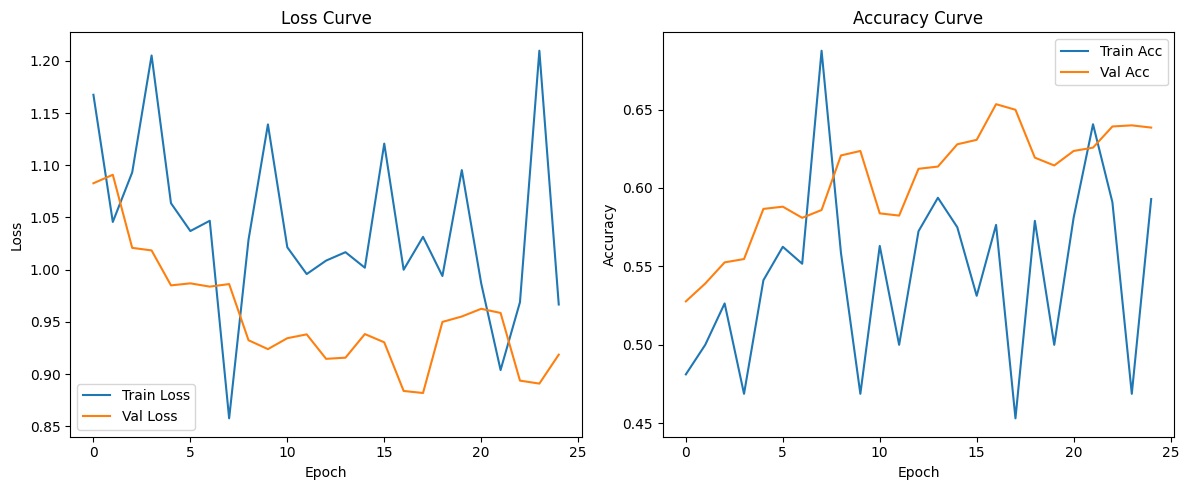

In [27]:
### 시각화 ###
import matplotlib.pyplot as plt

# 1) Figure 크기 설정
plt.figure(figsize=(12, 5))

# 2) Loss 곡선
plt.subplot(1, 2, 1)
plt.plot(history_res.history['loss'],     label='Train Loss')
plt.plot(history_res.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 3) Accuracy 곡선
plt.subplot(1, 2, 2)
plt.plot(history_res.history['accuracy'],     label='Train Acc')
plt.plot(history_res.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
